# Transfer learning with tf part 3: Scaling up
## Food Vision Mini

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

now we'll be working with all 101 classes of food

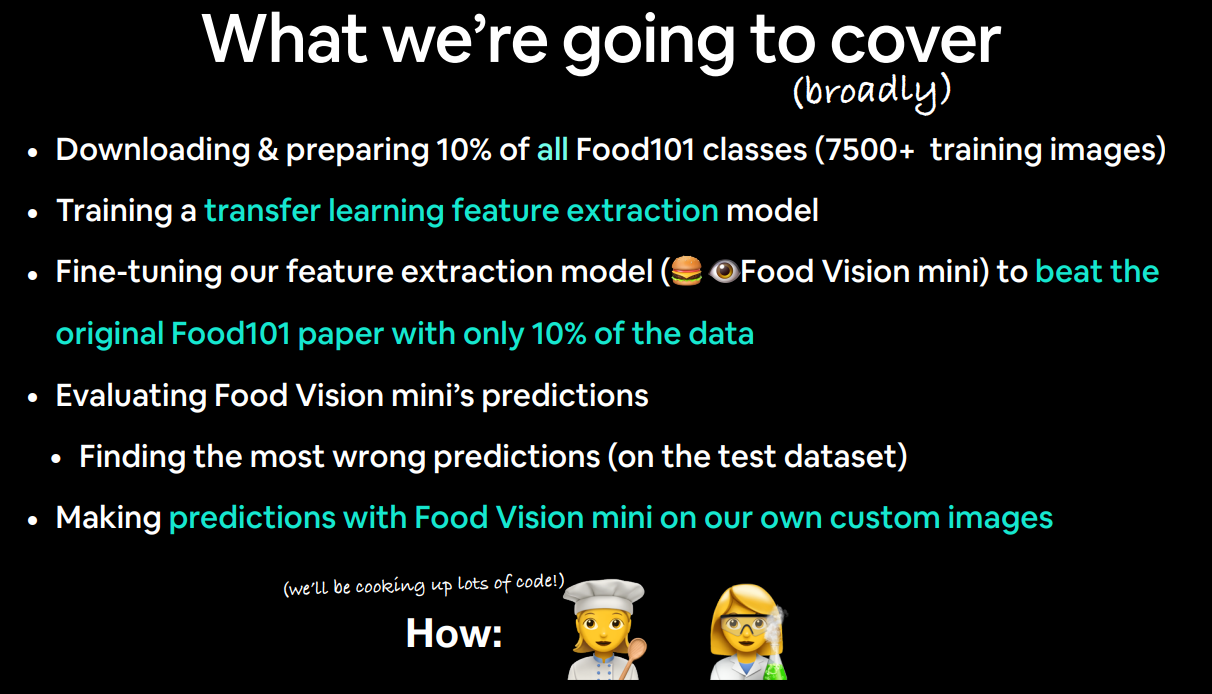

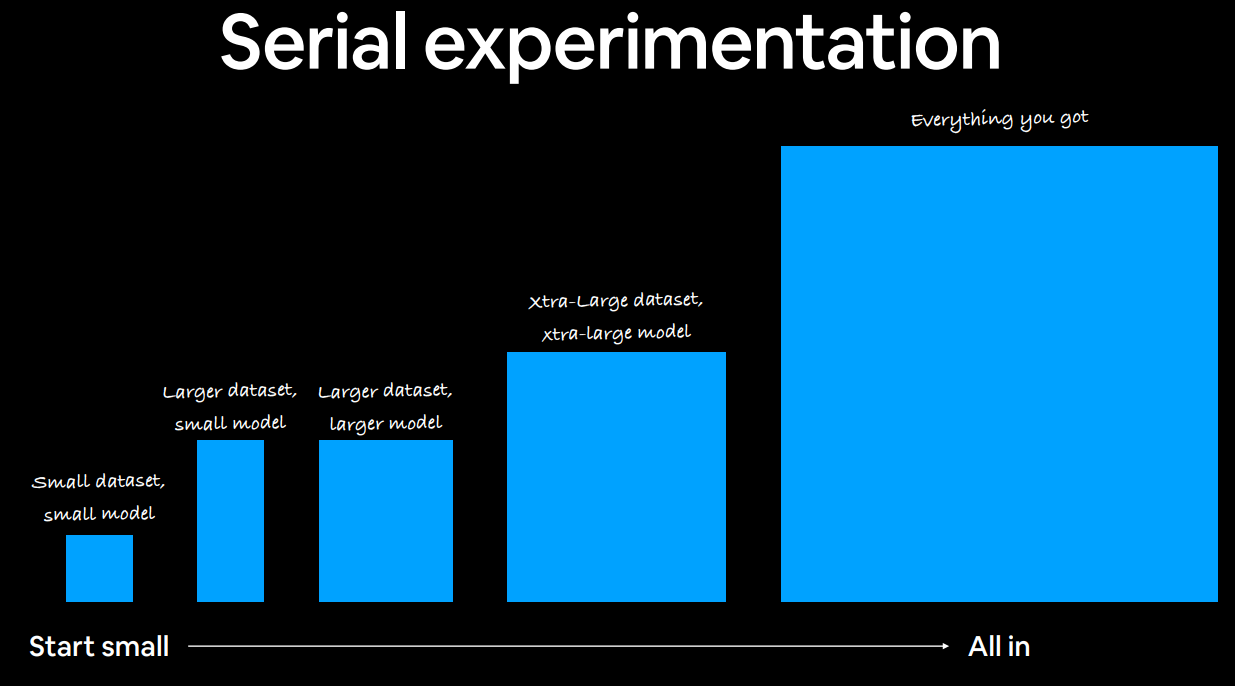

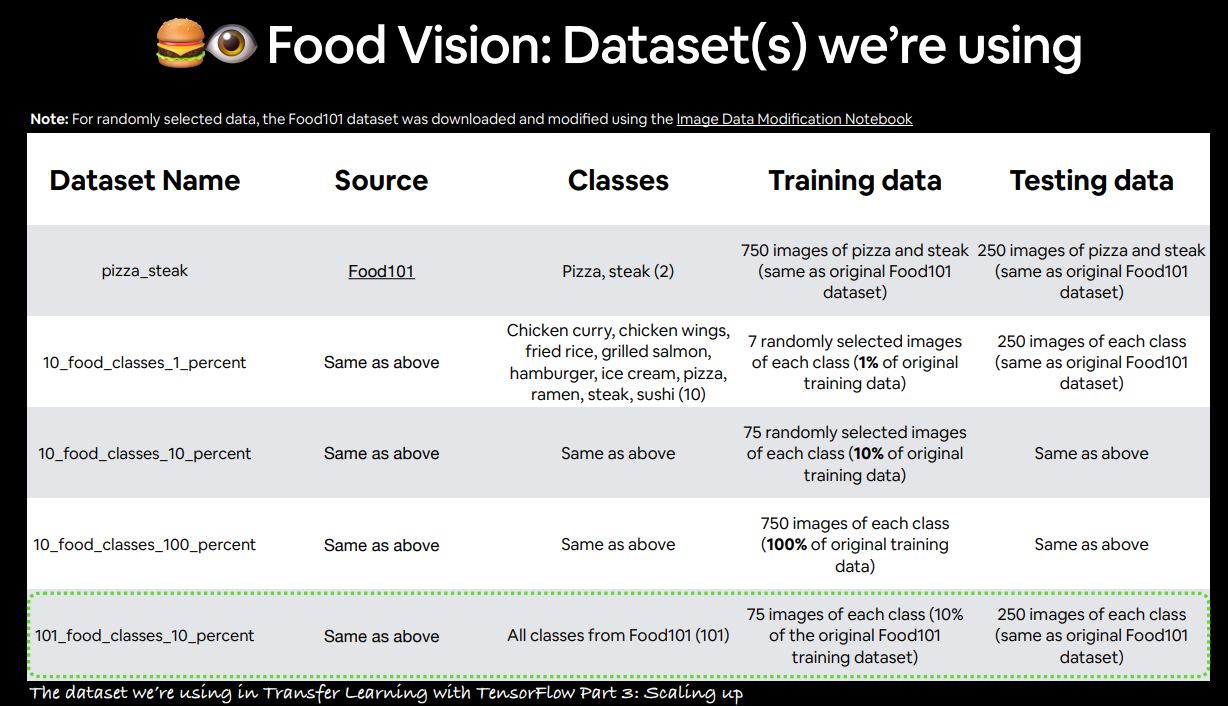

In [3]:
#insert helper functions that were created in previous videos
import helper_functions as hp
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys, walk_through_dir

## 101 food classes: working with less data
our goal is to beat the original food101 paper (50% on 101 classes) with 10% of the training data

In [4]:
train_dir = 'datasets/101_food_classes_10_percent/train/'
test_dir = 'datasets/101_food_classes_10_percent/test/'

In [5]:
#check how many images/classes are there?
walk_through_dir('datasets/101_food_classes_10_percent/')

There are 2 directories and 0 images in 'datasets/101_food_classes_10_percent/'.
There are 101 directories and 0 images in 'datasets/101_food_classes_10_percent/test'.
There are 0 directories and 250 images in 'datasets/101_food_classes_10_percent/test\apple_pie'.
There are 0 directories and 250 images in 'datasets/101_food_classes_10_percent/test\baby_back_ribs'.
There are 0 directories and 250 images in 'datasets/101_food_classes_10_percent/test\baklava'.
There are 0 directories and 250 images in 'datasets/101_food_classes_10_percent/test\beef_carpaccio'.
There are 0 directories and 250 images in 'datasets/101_food_classes_10_percent/test\beef_tartare'.
There are 0 directories and 250 images in 'datasets/101_food_classes_10_percent/test\beet_salad'.
There are 0 directories and 250 images in 'datasets/101_food_classes_10_percent/test\beignets'.
There are 0 directories and 250 images in 'datasets/101_food_classes_10_percent/test\bibimbap'.
There are 0 directories and 250 images in 'dat

### set up data inputs

In [6]:
IMG_SIZE = (224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode = 'categorical',
                                                                                image_size = IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               label_mode = 'categorical',
                                                               image_size = IMG_SIZE,
                                                               shuffle = False) #dont shuffle test data

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## train a big dog model with tf and 10% of 101 food classes

feature extraction transfer learning with a pre-trained efficientnet model and then we're going to fine tune it for a few more epochs

* set up a model checkpoint callback
* create a data augmentation layer to build data aug right into the model
* build a headless (no top layers) functional efficientnetb0 backboned model (we'll create our own output layer)
* compile our model
* feature extract for 5 epochs on the train dataset and validate on 15% of the test data to save epoch time)


In [8]:
# create checkpoint callback
checkpoint_path = '101_classes_10_percent_datda_model_checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                         monitor = 'val_accuracy',
                                                         save_weights_only= True,
                                                        save_best_only = True)

In [9]:
#create a data aug layer (when building this right into the model it has the benefit of running the aug
# right on the gpu)
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

In [10]:
#set up data aug
data_aug = Sequential([preprocessing.RandomFlip('horizontal'),
                      preprocessing.RandomRotation(0.2),
                      preprocessing.RandomHeight(0.2),
                      preprocessing.RandomWidth(0.2),
                      preprocessing.RandomZoom(0.2)
                      # preprocessing.Rescaling(1/255.) rescale if not using efficientnet (since its built in)
                      ], name = 'data_aug')

In [11]:
#build headless (no top layer) functional effientnetb0 backboned model
# setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

#setup model architecture with trainable top layers
inputs = layers.Input(shape = (224,224,3), name = 'input_layer')
x = data_aug(inputs) #augment images (only happens during training phase)
x = base_model(x, training = False) # this will put base model in inference mode so weights than need to stay frozen actually stay frozen)
x = layers.GlobalAveragePooling2D(name = 'gap')(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), 
                       activation = 'softmax', 
                       name = 'output_layer')(x)
model = tf.keras.Model(inputs, outputs)

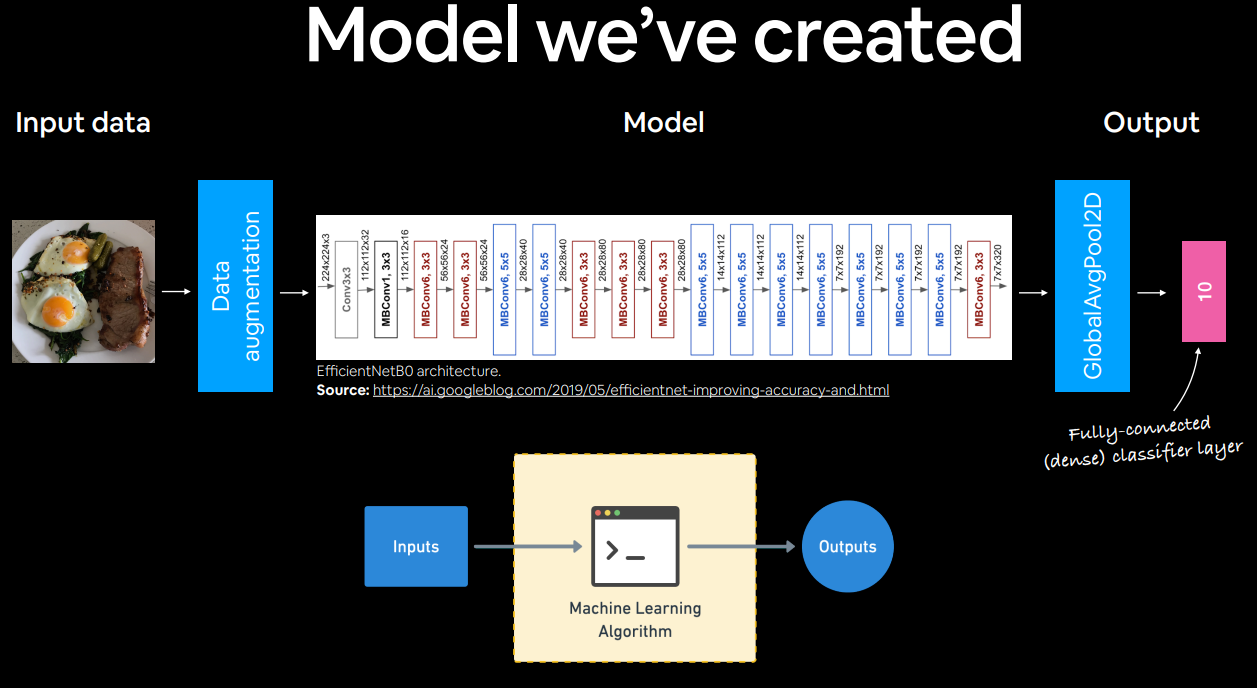

In [12]:
#get summary of model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_aug (Sequential)       (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 gap (GlobalAveragePooling2D  (None, 1280)             0         
 )                                                               
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_____________________________________________

In [13]:
#compile the model
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy'])

#fit the model
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                          epochs = 5, #fit to 5 additional epochs
                                          validation_data = test_data,
                                          validation_steps = int(0.15 * len(test_data)),
                                          callbacks = [checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 42s 148ms/step - loss: 3.3705 - accuracy: 0.2725 - val_loss: 2.3851 - val_accuracy: 0.4984
Epoch 2/5
237/237 [==============================] - 25s 103ms/step - loss: 2.1973 - accuracy: 0.4957 - val_loss: 1.9546 - val_accuracy: 0.5416
Epoch 3/5
237/237 [==============================] - 22s 90ms/step - loss: 1.8218 - accuracy: 0.5716 - val_loss: 1.7862 - val_accuracy: 0.5622
Epoch 4/5
237/237 [==============================] - 22s 91ms/step - loss: 1.6077 - accuracy: 0.6119 - val_loss: 1.7333 - val_accuracy: 0.5633
Epoch 5/5
237/237 [==============================] - 19s 82ms/step - loss: 1.4510 - accuracy: 0.6436 - val_loss: 1.6895 - val_accuracy: 0.5683


In [14]:
#evaluate on the whole test dataset

feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 22s 27ms/step - loss: 1.5812 - accuracy: 0.5828


[1.5811975002288818, 0.5827722549438477]

In [24]:
#we've beaten the baseline

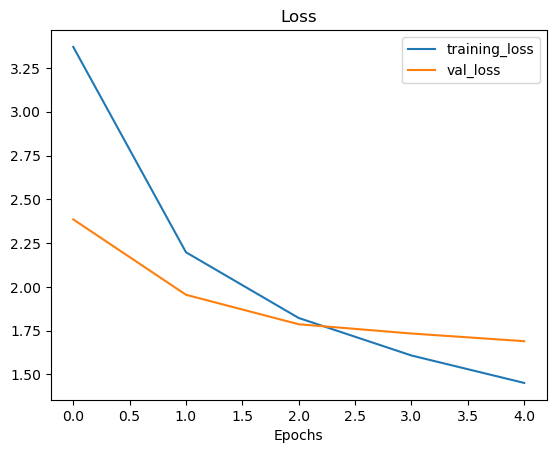

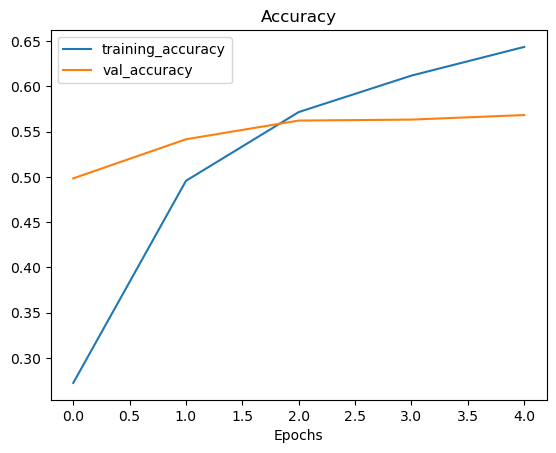

In [15]:
plot_loss_curves(history_all_classes_10_percent)
# curves show overfitting of the data
#i.e. its learning the training data but not the test data

In [16]:
#looks like some overfitting is occurring since the val accuracy isn't keeping up with the training accuracy

### fine tuning

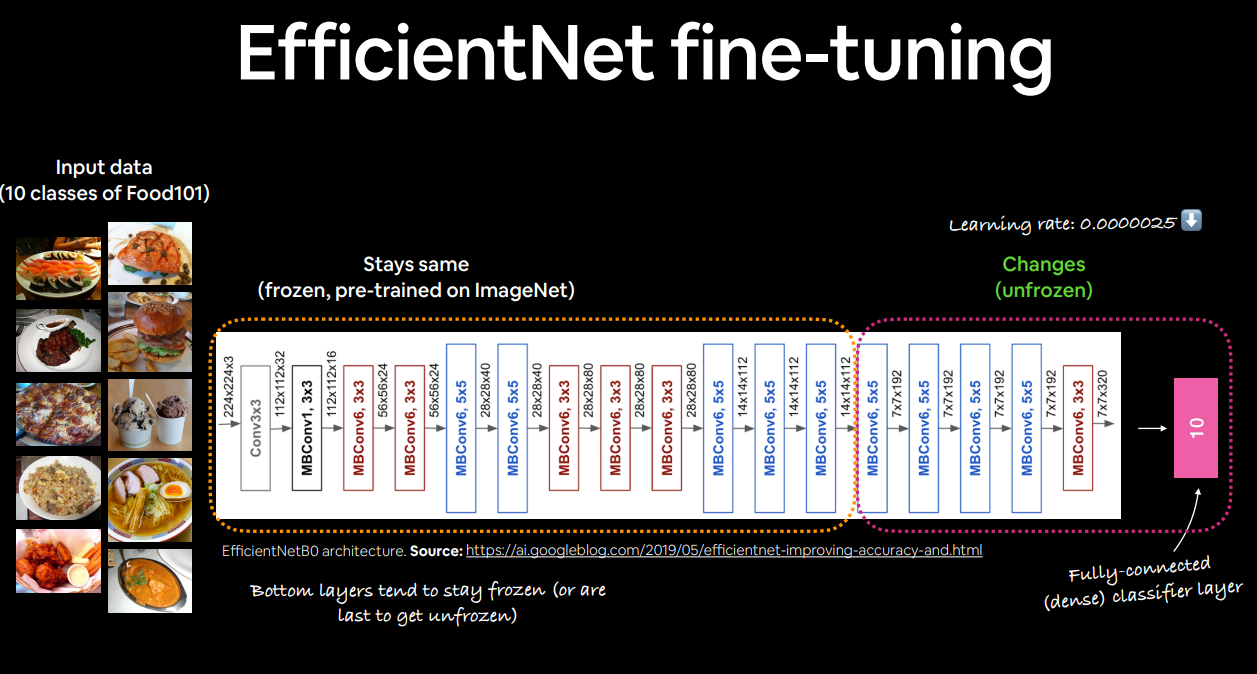

In [18]:
#unfreeze all layers in our base model to prepare for fine-tuning
base_model.trainable = True

#refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
    layer.trainable = False

In [19]:
#recompile model with lower learning rate (its best practice to lower lr by 10x)
#the more layers that are unfrozen the lower the learning rate needs to be
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
             optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
             metrics = ['accuracy'])

In [20]:
#what layers are trainable
for layer in model.layers:
    print(layer.name, layer.trainable)

input_layer True
data_aug True
efficientnetb0 True
gap True
output_layer True


In [21]:
#check which layers are trainable in our base_model
for layer_number, layer in enumerate(model.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 tf.math.truediv False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [22]:
#now we can fine tune the model starting off from 
#where we left off with our feature extraction model above

fine_tune_epochs = 10 #model has already done 5 epochs so now we want to do another 5

#fine tune the model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                    epochs = fine_tune_epochs,
                                                    validation_data = test_data,
                                                    validation_steps = int(0.15 * len(test_data)),
                                                    initial_epoch = history_all_classes_10_percent.epoch[-1])  #         

Epoch 5/10
237/237 [==============================] - 26s 94ms/step - loss: 1.2107 - accuracy: 0.6826 - val_loss: 1.6476 - val_accuracy: 0.5710
Epoch 6/10
237/237 [==============================] - 18s 76ms/step - loss: 1.0864 - accuracy: 0.7089 - val_loss: 1.6511 - val_accuracy: 0.5723
Epoch 7/10
237/237 [==============================] - 18s 75ms/step - loss: 1.0086 - accuracy: 0.7327 - val_loss: 1.6275 - val_accuracy: 0.5765
Epoch 8/10
237/237 [==============================] - 18s 74ms/step - loss: 0.9475 - accuracy: 0.7488 - val_loss: 1.6036 - val_accuracy: 0.5808
Epoch 9/10
237/237 [==============================] - 16s 69ms/step - loss: 0.8788 - accuracy: 0.7641 - val_loss: 1.6641 - val_accuracy: 0.5697
Epoch 10/10
237/237 [==============================] - 16s 69ms/step - loss: 0.8313 - accuracy: 0.7770 - val_loss: 1.6317 - val_accuracy: 0.5771


In [23]:
#evaluate on the whole test data
fine_tuning_results = model.evaluate(test_data)
fine_tuning_results

790/790 [==============================] - 21s 27ms/step - loss: 1.4998 - accuracy: 0.6017


[1.4998143911361694, 0.6017425656318665]

In [35]:
#we can see the accuracy increase by 2% or so when doing fine-tuning

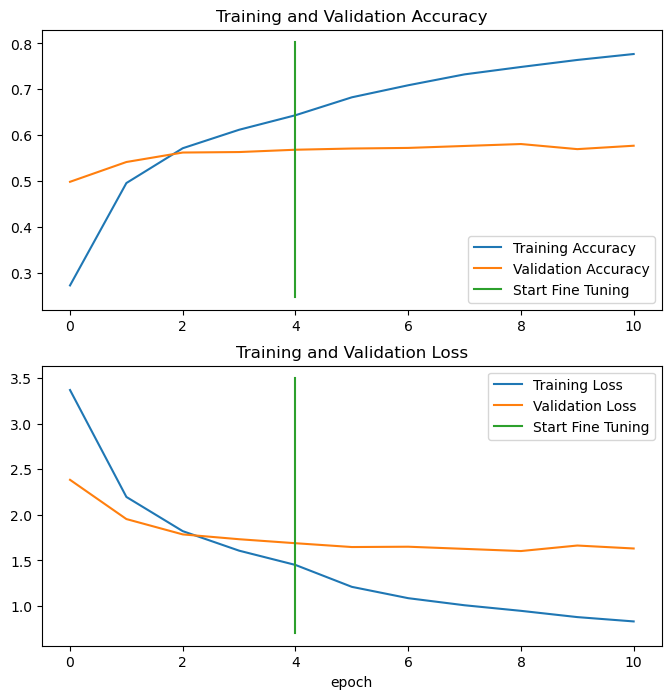

In [25]:
#compare the histories of feature extraction model with fine tuning model
compare_historys(original_history = history_all_classes_10_percent, 
                 new_history= history_all_classes_10_percent_fine_tune, 
                 initial_epochs = 5)

the seperation of the curves implies there is still overfitting going on.
how to prevent overfitting?


### saving and loading our trained model
to use our model in an external aplication we'll ned to save it and export it somewhere

In [26]:
model.save('101_food_classes_10_percent_model')

INFO:tensorflow:Assets written to: 101_food_classes_10_percent_model\assets


INFO:tensorflow:Assets written to: 101_food_classes_10_percent_model\assets


In [27]:
#load and evaluate saved model
loaded_model = tf.keras.models.load_model('101_food_classes_10_percent_model/')

In [28]:
loaded_model.evaluate(test_data)

790/790 [==============================] - 21s 26ms/step - loss: 1.4998 - accuracy: 0.6017


[1.4998143911361694, 0.6017425656318665]

In [41]:
#saved model has same performance as the model before saving.

### evaluating performance model across all different classes
let's make some predictions, viz them, and then find out which predictions were the most wrong.

In [36]:
big_dog_model = tf.keras.models.load_model('datasets/101_food_class_10_percent_saved_big_dog_model/')
#can ignore the warning messages below

In [37]:
big_dog_model.evaluate(test_data)

790/790 [==============================] - 21s 26ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]

In [38]:
big_dog_model.summary()

Model: "functional_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_9   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 4,136,929
Non-trainable params: 42,023
______________________________________

### making predictions with our trained model

In [39]:
pred_probs = big_dog_model.predict(test_data, verbose = 1) #set verbosity to see how long is left

790/790 [==============================] - 19s 23ms/step


In [42]:
#one pred for every image in our test set.
pred_probs.shape #each pred is a vector of length 101 to contain every possible output value

(25250, 101)

In [43]:
#ltes see what the first 10 predictions look like
pred_probs[:10]

array([[5.9542086e-02, 3.5742116e-06, 4.1376837e-02, ..., 1.4138707e-09,
        8.3530584e-05, 3.0897409e-03],
       [9.6401680e-01, 1.3753220e-09, 8.4780209e-04, ..., 5.4286946e-05,
        7.8362204e-12, 9.8466024e-10],
       [9.5925879e-01, 3.2533528e-05, 1.4866899e-03, ..., 7.1891003e-07,
        5.4397378e-07, 4.0275892e-05],
       ...,
       [4.7313181e-01, 1.2931235e-07, 1.4805638e-03, ..., 5.9750059e-04,
        6.6969231e-05, 2.3469345e-05],
       [4.4571880e-02, 4.7265436e-07, 1.2258496e-01, ..., 6.3498264e-06,
        7.5318449e-06, 3.6778711e-03],
       [7.2438961e-01, 1.9249846e-09, 5.2311338e-05, ..., 1.2291444e-03,
        1.5792775e-09, 9.6396026e-05]], dtype=float32)

In [44]:
#what does the first pred prob array look like
pred_probs[0]

array([5.95420860e-02, 3.57421163e-06, 4.13768366e-02, 1.06605547e-09,
       8.16141199e-09, 8.66396554e-09, 8.09268897e-07, 8.56522490e-07,
       1.98590351e-05, 8.09773724e-07, 3.17276827e-09, 9.86737405e-07,
       2.85322312e-04, 7.80487452e-10, 7.42300530e-04, 3.89163033e-05,
       6.47403658e-06, 2.49772552e-06, 3.78910954e-05, 2.06782488e-07,
       1.55384369e-05, 8.15071758e-07, 2.62305161e-06, 2.00106470e-07,
       8.38276890e-07, 5.42157250e-06, 3.73910325e-06, 1.31505580e-08,
       2.77614966e-03, 2.80519198e-05, 6.85620227e-10, 2.55748073e-05,
       1.66889280e-04, 7.64067087e-10, 4.04527382e-04, 1.31506841e-08,
       1.79573601e-06, 1.44482021e-06, 2.30629109e-02, 8.24668518e-07,
       8.53655308e-07, 1.71385614e-06, 7.05249022e-06, 1.84022362e-08,
       2.85534270e-07, 7.94833068e-06, 2.06814525e-06, 1.85251878e-07,
       3.36195782e-08, 3.15224781e-04, 1.04109422e-05, 8.54484426e-07,
       8.47418606e-01, 1.05554245e-05, 4.40948753e-07, 3.74041047e-05,
      

In [45]:
#all values should add up to 0
sum(pred_probs[0])

0.9999999511063582

In [46]:
# we get one prediction probability per class. in our class theres 101 probabilities
print(f'number of pred probabilities for sample 0: {len(pred_probs[0])}')
print(f'what pred prob sample 0 looks like: {pred_probs[0]}')
print(f'class with the highest pred probability for sample 0: {tf.argmax(pred_probs[0])}')

number of pred probabilities for sample 0: 101
what pred prob sample 0 looks like: [5.95420860e-02 3.57421163e-06 4.13768366e-02 1.06605547e-09
 8.16141199e-09 8.66396554e-09 8.09268897e-07 8.56522490e-07
 1.98590351e-05 8.09773724e-07 3.17276827e-09 9.86737405e-07
 2.85322312e-04 7.80487452e-10 7.42300530e-04 3.89163033e-05
 6.47403658e-06 2.49772552e-06 3.78910954e-05 2.06782488e-07
 1.55384369e-05 8.15071758e-07 2.62305161e-06 2.00106470e-07
 8.38276890e-07 5.42157250e-06 3.73910325e-06 1.31505580e-08
 2.77614966e-03 2.80519198e-05 6.85620227e-10 2.55748073e-05
 1.66889280e-04 7.64067087e-10 4.04527382e-04 1.31506841e-08
 1.79573601e-06 1.44482021e-06 2.30629109e-02 8.24668518e-07
 8.53655308e-07 1.71385614e-06 7.05249022e-06 1.84022362e-08
 2.85534270e-07 7.94833068e-06 2.06814525e-06 1.85251878e-07
 3.36195782e-08 3.15224781e-04 1.04109422e-05 8.54484426e-07
 8.47418606e-01 1.05554245e-05 4.40948753e-07 3.74041047e-05
 3.53061914e-05 3.24889443e-05 6.73146133e-05 1.28525421e-08
 2

In [47]:
test_data.class_names[52]

'gyoza'

In [49]:
#get pred classes for each label

pred_classes = pred_probs.argmax(axis = 1)

#how do they look
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0], dtype=int64)

In [50]:
#how many pred classes do we have
len(pred_classes) #one predicted class for each image in our dataset

25250

In [52]:
#now we have an array of our predictions. we need to compoare those predictions to the ground truth labels
#we have to unravel our test dataset which is in batches.
y_labels = []
for images, labels in test_data.unbatch(): #unbatching is kind of slow
    y_labels.append(labels.numpy().argmax()) #currently test labels are one hot encoded so getting argmax
    #will return the index that's set to 1
y_labels[::100] #look at the first 10

[0,
 0,
 0,
 1,
 1,
 2,
 2,
 2,
 3,
 3,
 4,
 4,
 4,
 5,
 5,
 6,
 6,
 6,
 7,
 7,
 8,
 8,
 8,
 9,
 9,
 10,
 10,
 10,
 11,
 11,
 12,
 12,
 12,
 13,
 13,
 14,
 14,
 14,
 15,
 15,
 16,
 16,
 16,
 17,
 17,
 18,
 18,
 18,
 19,
 19,
 20,
 20,
 20,
 21,
 21,
 22,
 22,
 22,
 23,
 23,
 24,
 24,
 24,
 25,
 25,
 26,
 26,
 26,
 27,
 27,
 28,
 28,
 28,
 29,
 29,
 30,
 30,
 30,
 31,
 31,
 32,
 32,
 32,
 33,
 33,
 34,
 34,
 34,
 35,
 35,
 36,
 36,
 36,
 37,
 37,
 38,
 38,
 38,
 39,
 39,
 40,
 40,
 40,
 41,
 41,
 42,
 42,
 42,
 43,
 43,
 44,
 44,
 44,
 45,
 45,
 46,
 46,
 46,
 47,
 47,
 48,
 48,
 48,
 49,
 49,
 50,
 50,
 50,
 51,
 51,
 52,
 52,
 52,
 53,
 53,
 54,
 54,
 54,
 55,
 55,
 56,
 56,
 56,
 57,
 57,
 58,
 58,
 58,
 59,
 59,
 60,
 60,
 60,
 61,
 61,
 62,
 62,
 62,
 63,
 63,
 64,
 64,
 64,
 65,
 65,
 66,
 66,
 66,
 67,
 67,
 68,
 68,
 68,
 69,
 69,
 70,
 70,
 70,
 71,
 71,
 72,
 72,
 72,
 73,
 73,
 74,
 74,
 74,
 75,
 75,
 76,
 76,
 76,
 77,
 77,
 78,
 78,
 78,
 79,
 79,
 80,
 80,
 80,
 81,
 81,


In [53]:
len(y_labels)

25250

In [55]:
#one way we can check to see if our prediction labels are in the same order as the our 
#test_Labels is to find the accuracy score 
from sklearn.metrics import accuracy_score
accuracy_score(y_labels, pred_classes)

0.6077623762376237

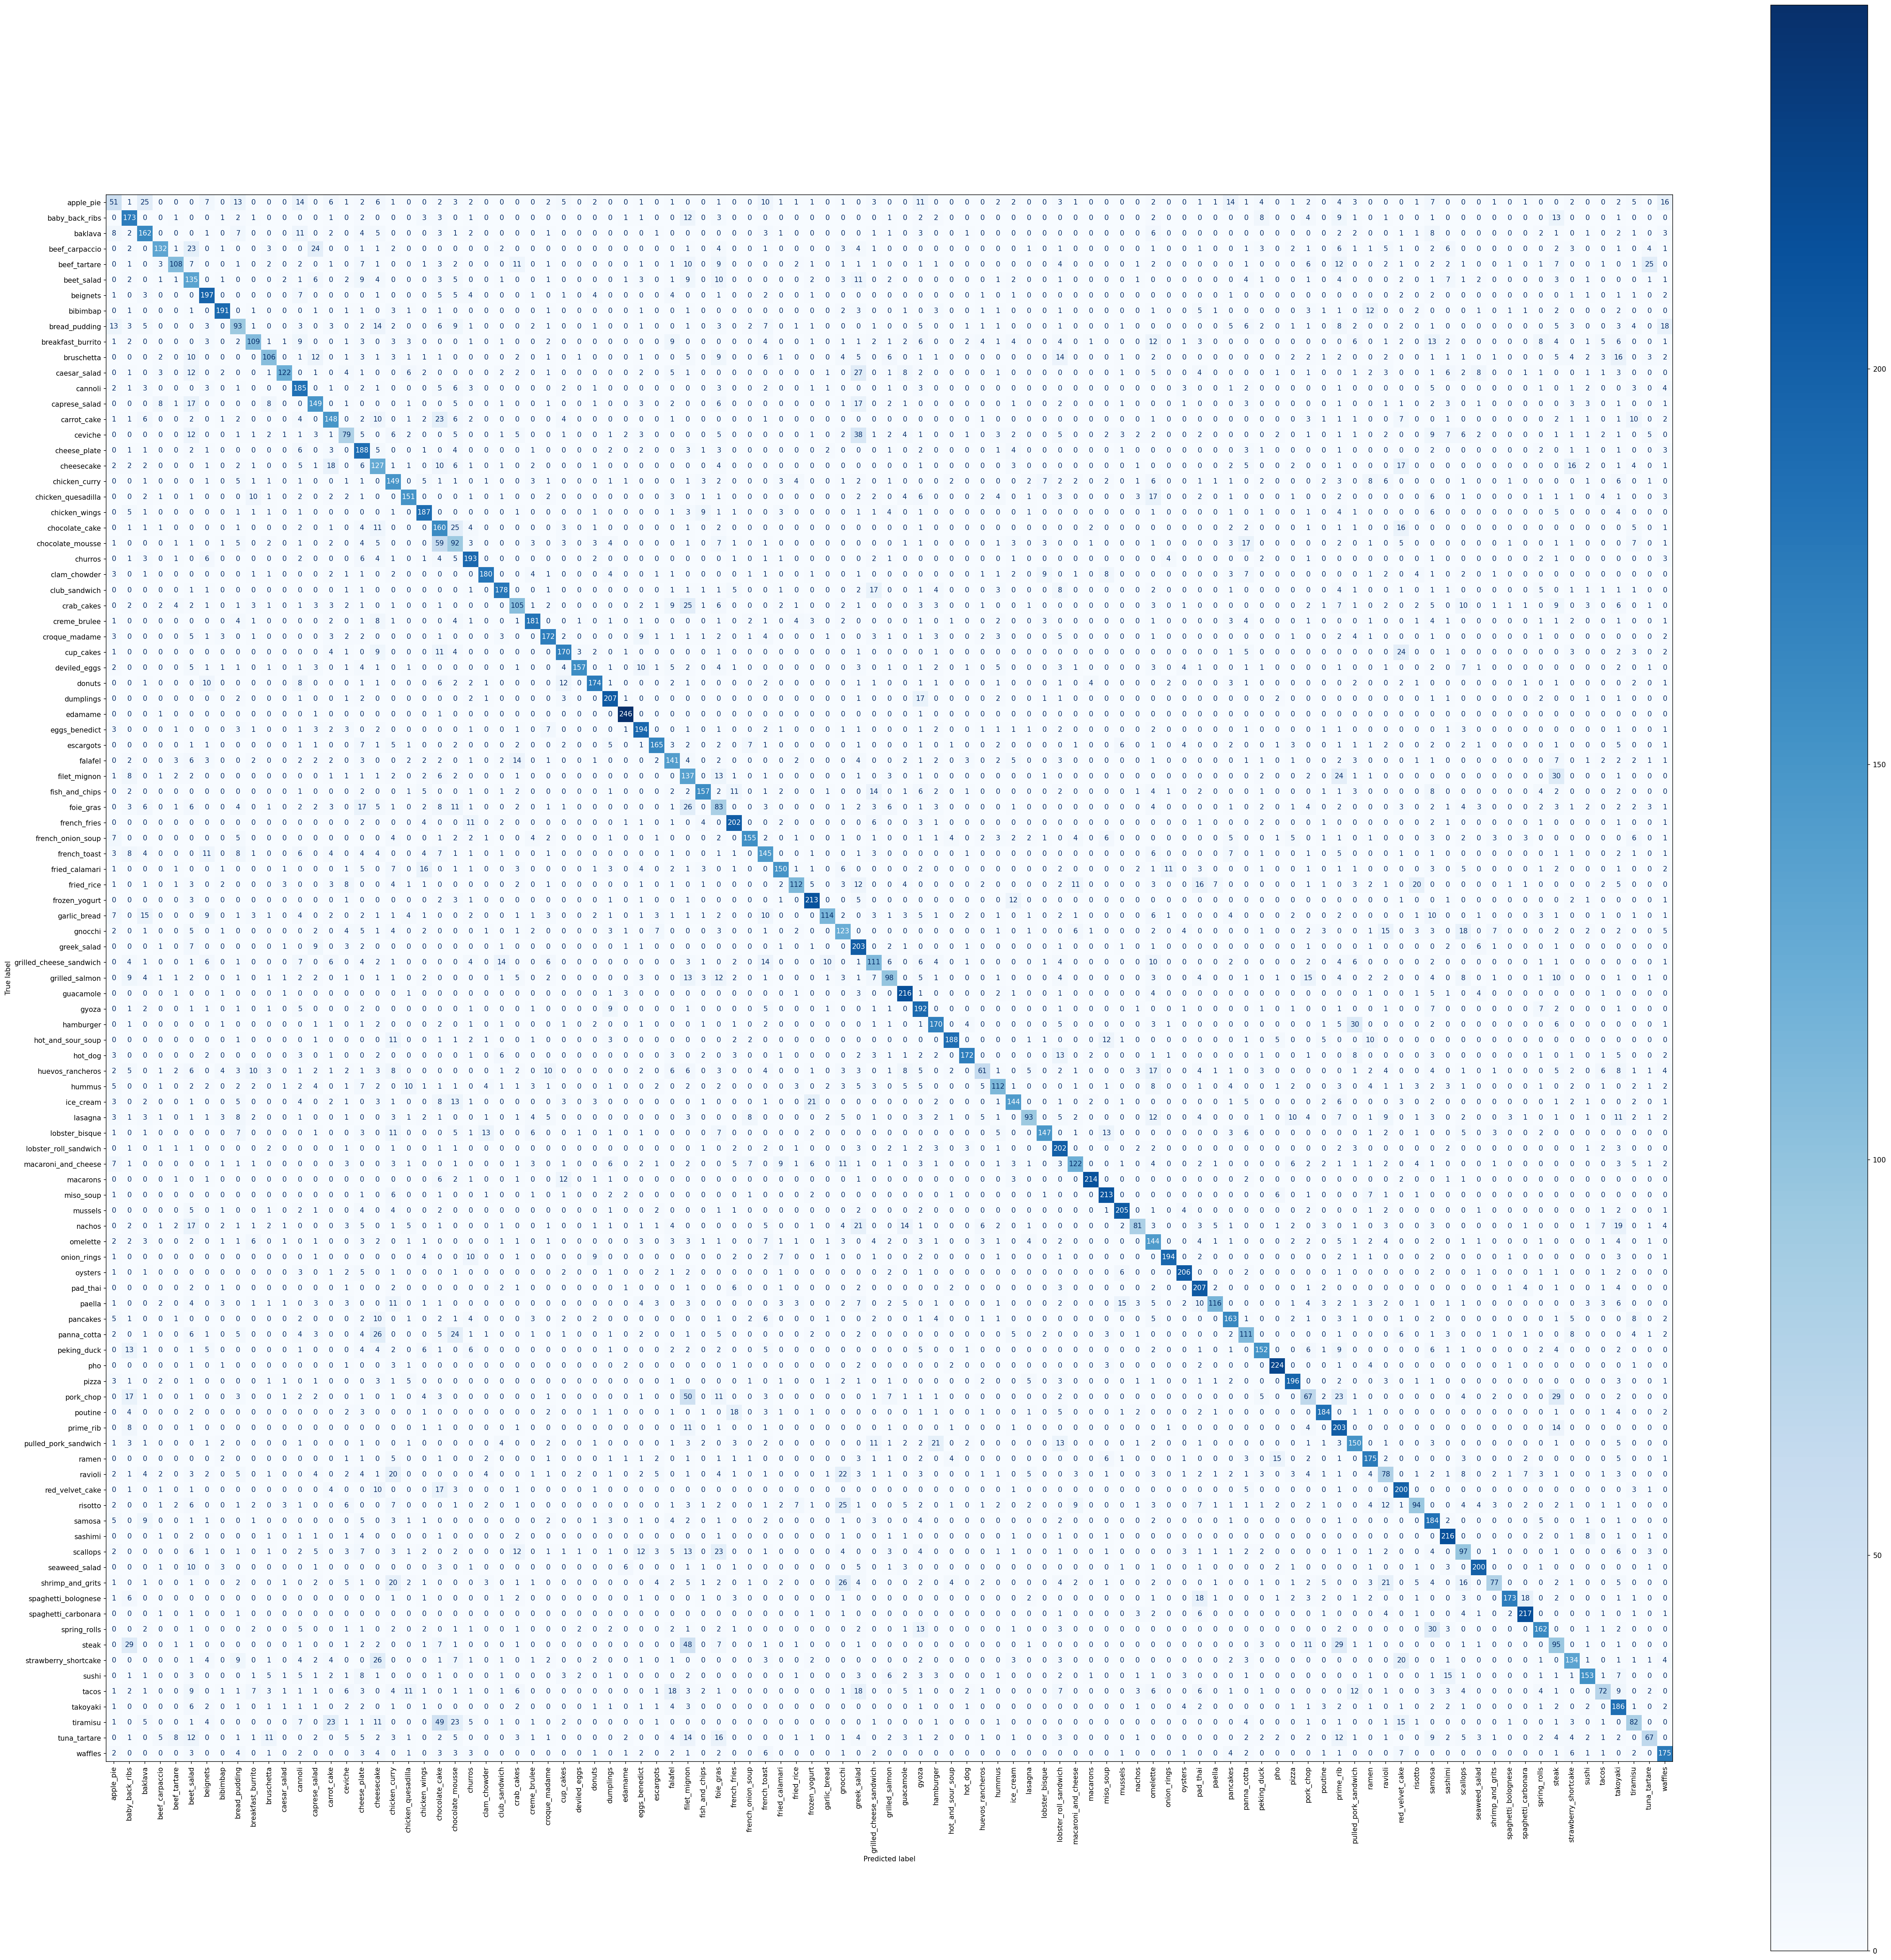

In [69]:
#confusion matrix with all 101 classes
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
#get a list of class names
class_names = test_data.class_names

 
ConfusionMatrixDisplay.from_predictions(y_true=y_labels,
                                        y_pred=pred_classes,
                                        display_labels=class_names,
                                        cmap="Blues",
                                        xticks_rotation="vertical",
                                        # make it bigger
                                        ax=plt.figure(figsize=(50, 50), dpi=150).subplots())

In [71]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

#precision is tp/tp+fp
#recall is tp/tp+fn

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

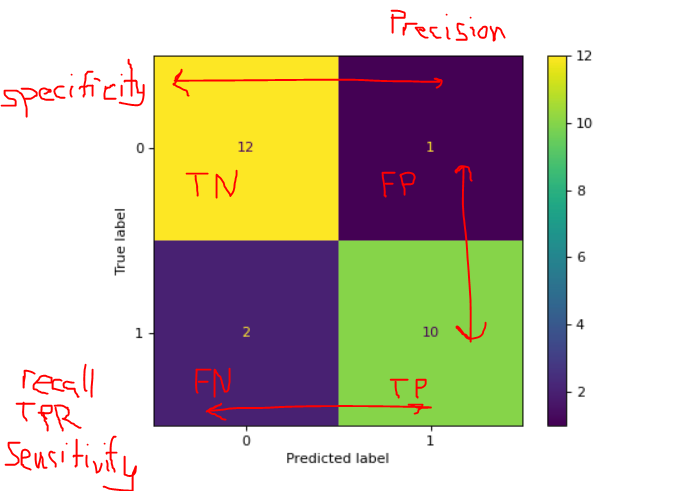

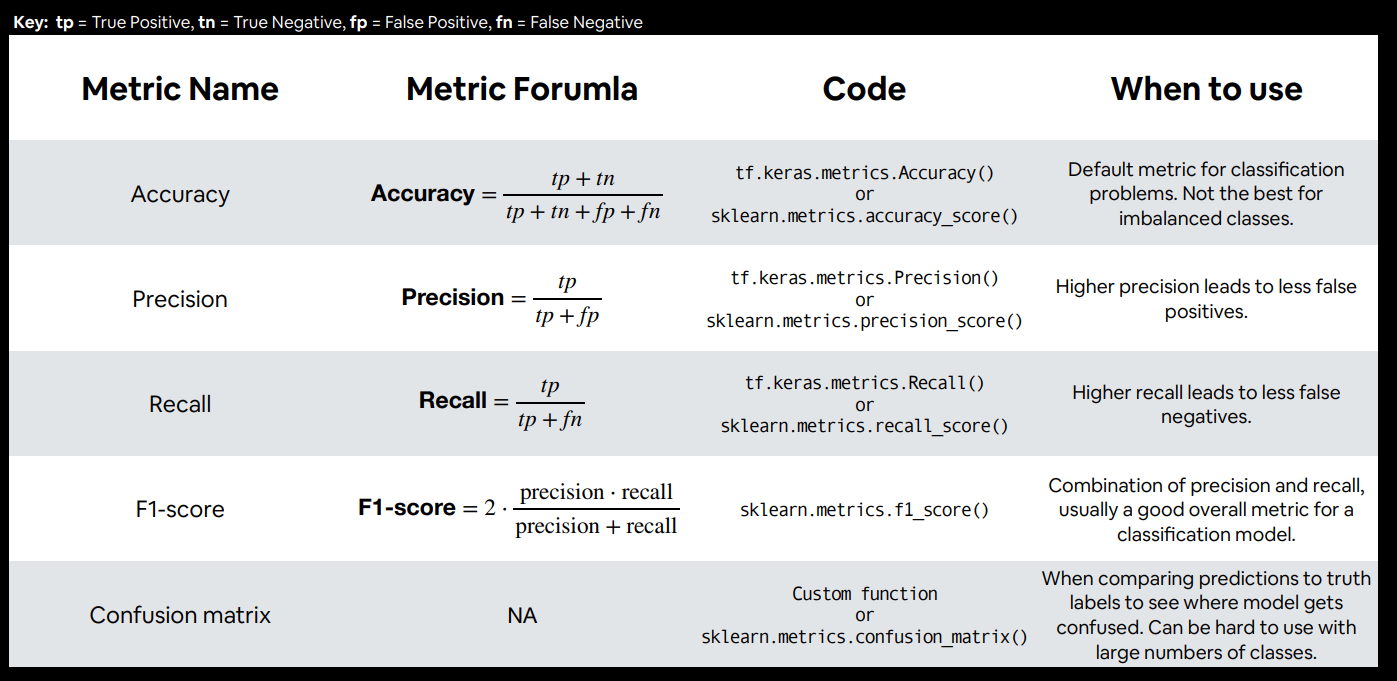

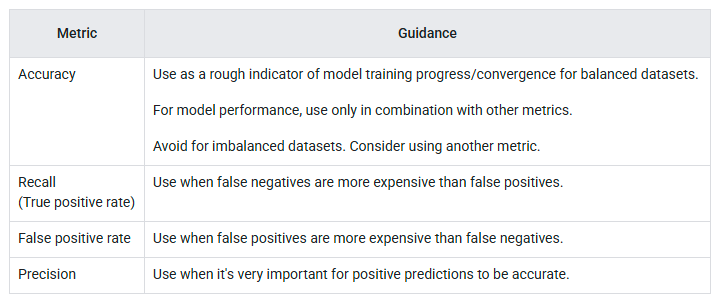

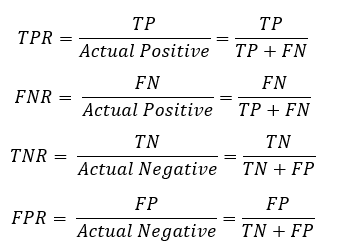

In [ ]:
#plot each class with its f1 score
#get a dict of classification report